## Column Definitions

Data comes from: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

1. age: (numeric)
2. job: type of job (categorical: "admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "selfemployed", "services", "student", "technician", "unemployed", "unknown")
3. marital: marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
4. education (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")
5. default: has credit in default? (categorical: "no", "yes", "unknown")
6. housing: has housing loan? (categorical: "no","yes","unknown")
7. loan: has personal loan? (categorical: "no", "yes", "unknown")

#### related with the last contact of the current campaign:
8. contact: contact communication type (categorical: "cellular", "telephone") 
9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
10. day_of_week: last contact day of the week (categorical: "mon", "tue", "wed", "thu", "fri")
11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

#### social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)     
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: "yes","no")

## Import Libraries

In [26]:
import pandas as pd
import seaborn as sns
import eli5
import matplotlib.pyplot as plt
%matplotlib inline

from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Read data and drop "duration" column since this column is collected after label is observed.
df = pd.read_csv(r'C:/Users/mzhang40/data/bank_marketing/bank-additional-full.csv', delimiter=';')
df = df.drop(['duration'], axis=1)

# Create dummy variables and train/test split
df_dummy = pd.concat([pd.get_dummies(df.drop(['y'], axis=1)), df.y], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_dummy.drop(['y'], axis=1), df_dummy.y, test_size=0.3, random_state=1)

seed = 1;

## Fit Models

In [50]:
rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier(random_state=seed)
gb_model.fit(X_train, y_train)

logit_model = LogisticRegression(max_iter=1000, random_state=seed)
logit_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1)

## Feature Distributions

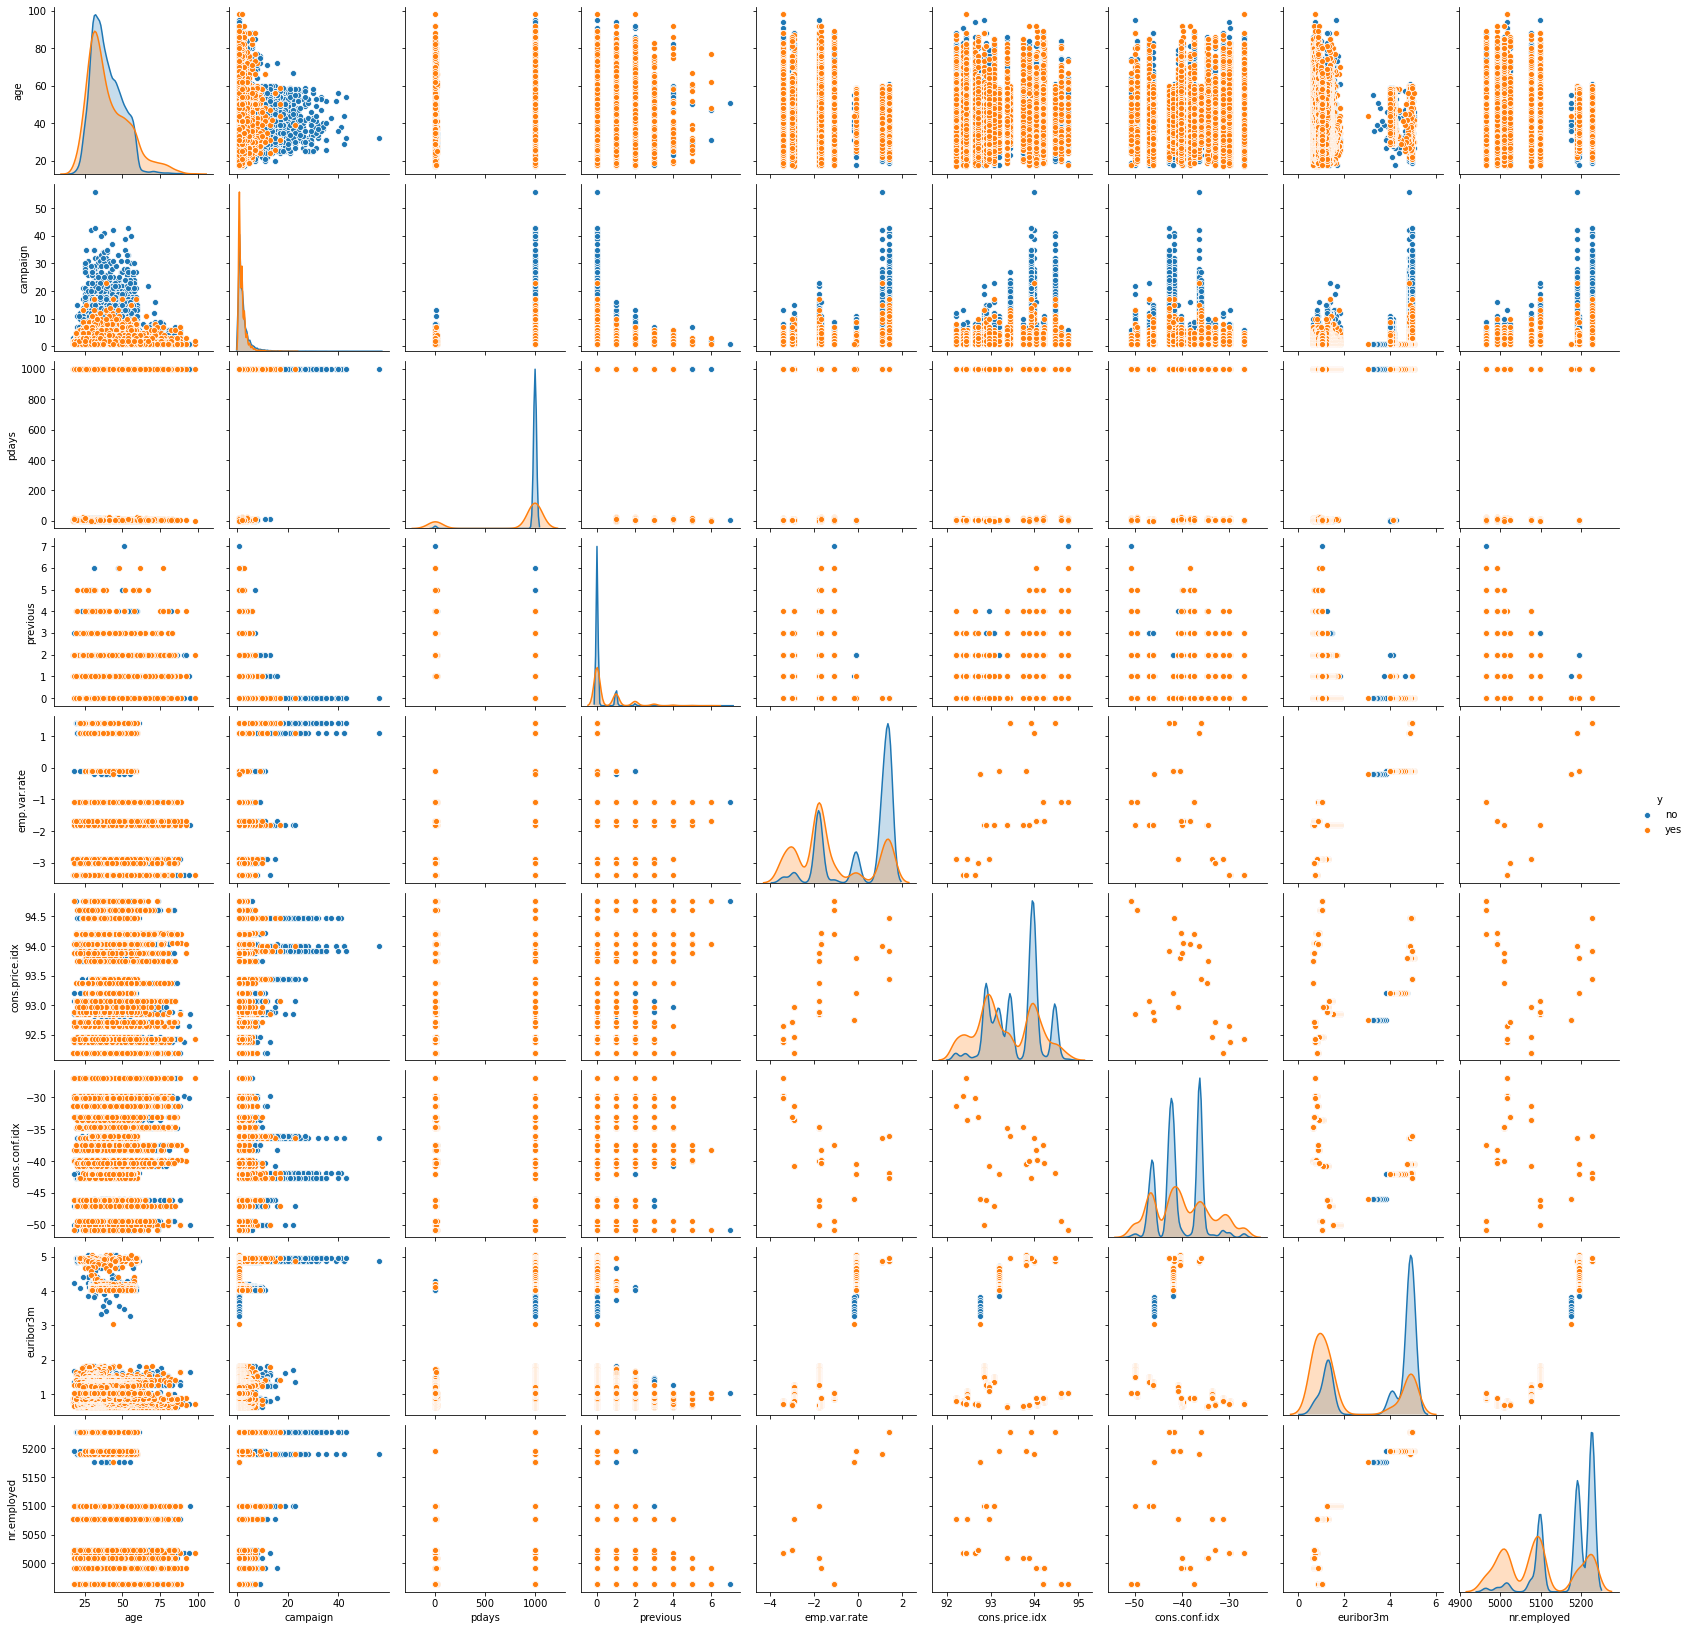

In [25]:
sns.pairplot(pd.concat([df.select_dtypes(exclude='object'), df.y], axis=1), hue='y')

## Define Functions To Show Feature Importance

In [51]:
def featureImp(model, trainSet, top_n=20, ax=0):
    feature_imp = pd.Series(data=model.feature_importances_, index=trainSet.columns)[:top_n].sort_values(ascending=False)
    sns.barplot(feature_imp.values, feature_imp.index, ax=ax)
    
def permutationImp(model, X_test, y_test):
    perm = PermutationImportance(model, random_state=seed).fit(X_test, y_test)
    return eli5.show_weights(perm, feature_names=X_test.columns.tolist())

## Feature Importance by Random Forest and Gradient Boosting

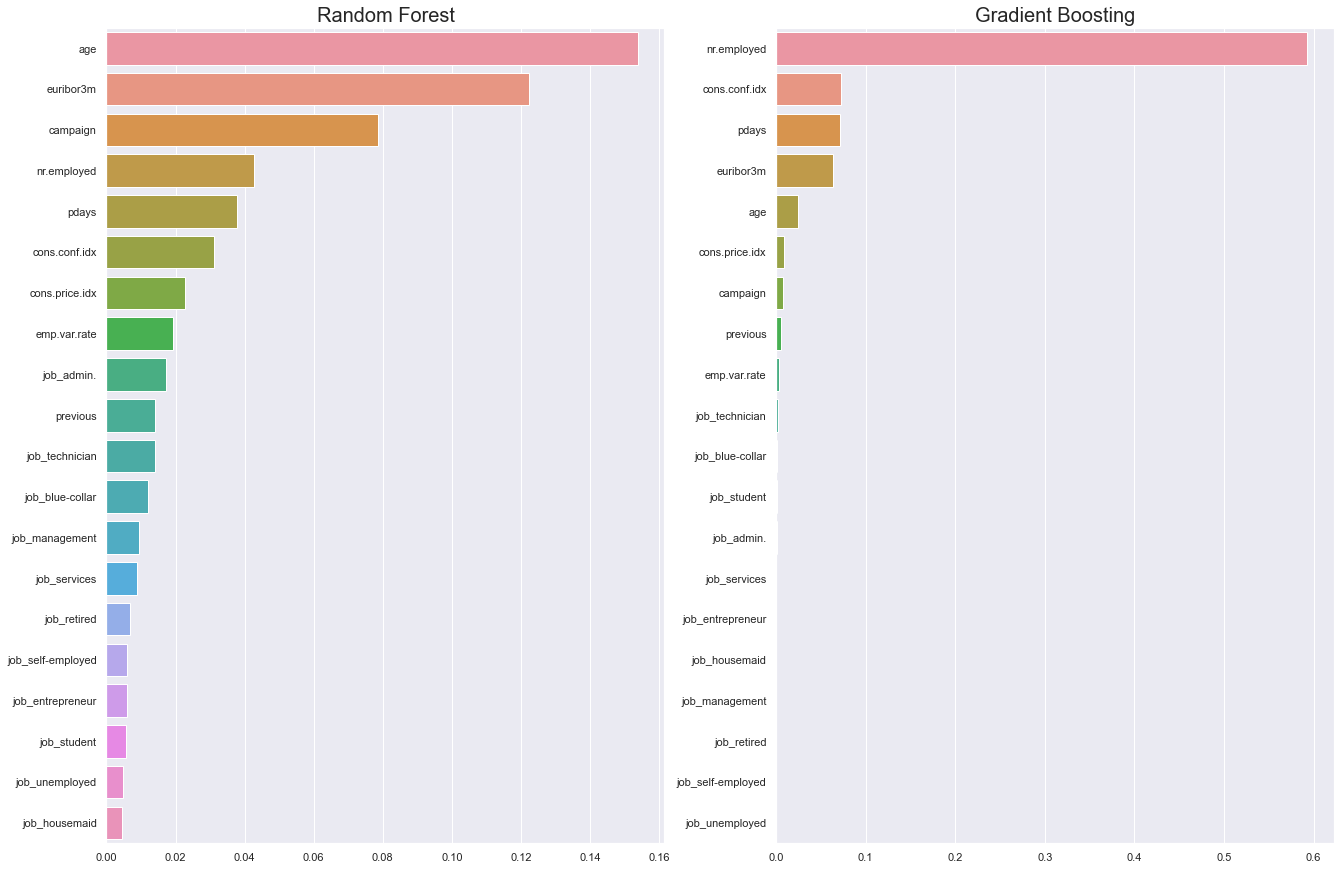

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(22, 15))
featureImp(rf_model, X_train, ax=axes[0])
featureImp(gb_model, X_train, ax=axes[1])
axes[0].set_title('Random Forest', fontsize=20)
axes[1].set_title('Gradient Boosting', fontsize=20);

## Permutation Importance by Random Forest

In [53]:
permutationImp(rf_model, X_test, y_test)

Weight,Feature
0.0025 ± 0.0006,pdays
0.0008 ± 0.0003,month_oct
0.0005 ± 0.0002,month_apr
0.0004 ± 0.0007,poutcome_failure
0.0002 ± 0.0004,poutcome_success
0.0000 ± 0.0004,job_self-employed
0.0000 ± 0.0001,job_unknown
0 ± 0.0000,default_yes
0 ± 0.0000,education_illiterate
-0.0000 ± 0.0001,marital_unknown


## Permutation Importance by Gradient Boosting

In [54]:
permutationImp(gb_model, X_test, y_test)

Weight,Feature
0.0104 ± 0.0005,nr.employed
0.0078 ± 0.0012,month_oct
0.0028 ± 0.0009,euribor3m
0.0027 ± 0.0014,pdays
0.0014 ± 0.0005,poutcome_success
0.0012 ± 0.0003,campaign
0.0011 ± 0.0005,poutcome_failure
0.0010 ± 0.0010,day_of_week_mon
0.0006 ± 0.0005,contact_telephone
0.0005 ± 0.0002,job_student


## Permutation Importance by Logistic Regression

In [55]:
permutationImp(logit_model, X_test, y_test)

Weight,Feature
0.0129 ± 0.0019,pdays
0.0079 ± 0.0016,nr.employed
0.0022 ± 0.0006,euribor3m
0.0019 ± 0.0017,emp.var.rate
0.0017 ± 0.0012,cons.price.idx
0.0009 ± 0.0007,month_may
0.0008 ± 0.0006,contact_cellular
0.0007 ± 0.0010,contact_telephone
0.0006 ± 0.0005,education_university.degree
0.0005 ± 0.0003,campaign
